In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns

from astropy.io import ascii
from datetime import datetime
from mpl_toolkits.basemap import Basemap, solar
from matplotlib.colors import ListedColormap
from pyhdf.SD import SD, SDC 
from scipy import stats

from func import getSDS, avg2, binavg, submatrx_mode, modismap, ctp_cot

In this notebook, I will be attempting to consolidate the many cells of code which creates the 90x180 rebinned grids in previous notebooks to (hopefull) singular functions. Then, I will try to plot land cover with contours showing cloud optical thickness and cloud top pressure 

## first, land cover

In [2]:
def terminator(date):
    
    '''
    inputs: date - solar.datetime object
    
    output: np
    '''

    lons2, lats2, daynight = solar.daynight_grid(dat, 2, -180, 179)   # gets grid of day/night values, night = 1, day = NaN

    daynight = np.delete(daynight, 90, 0)   # gets daynight to be 90x180
    daynight = daynight[::-1]               # corrects lat/lon to same as MODIS data
    
    return daynight

def landtypes(landfile, snowfile, landsds_name, snowsds_name, daynight, in_res = 0.05):
    
    '''
    inputs: landfile (str) - path to HDF file containing MODIS land cover data (MCD12C1)
            snowfile (str) - path to HDF file containing MODIS snow cover data (MYD10C1)
            landsds_name (str) - name of desired SDS from MODIS land cover file
            snowsds_name (str) - name of desired SDS from MODIS snow cover file
            daynight - numpy masked array (output of local function func.terminator)
            in_res - resolution of input data in degrees
            
    output - landcover - 90 x 180 numpy array of integers showing land type (from func.modismap)
    '''
    
    itdat = range(90)      # used for iterating through cot and ctp data
    itdat2 = range(180)
    

    #----------SNOW DATA-----------------#
    snowhdf = SD(snowfile, SDC.READ) 
    snowsds = snowhdf.select(snowsds_name)
    snowvals = np.array(snowsds.get())


    #----------LAND DATA-----------------#
    landhdf = SD(landfile, SDC.READ) 
    landsds = landhdf.select(landsds_name)
    landvals = np.array(landsds.get())

    landmodes = submatrx_mode(landvals, in_res)   # rebins yearly data to 2x2
    snowmodes = submatrx_mode(snowvals, in_res)   # "

    landcover = modismap(landmodes) 

    for i in range(len(snowmodes[0:74])):
        for j in range(len(snowmodes[i])):   # this is the world above lat -60 deg.
            if (snowmodes[i][j] > 0) and (snowmodes[i][j] <= 100):

                landcover[i][j] = 5   # this changes snow values to value corresponding to snow in land data

    for i in range(len(daynight)):
        for j in range(len(daynight[i])):
            if daynight[i][j] == 1.0:
                landcover[i][j] = np.nan

    west_edge = range(0,26)
    east_edge = range(115,180)
    
    print landcover

    # makes values None outside of lon range

    for i in itdat:
        for j in west_edge:
            landcover[i][j] = np.nan

    for i in itdat:
        for j in east_edge:
            landcover[i][j] = np.nan
            
    return landcover

In [3]:
dat = datetime(2013,5,18,21,20,0)   # date of observation at time 21:20 UT

daynight = terminator(dat)

snowfile = 'MYD10C1_5.18.2013.hdf' 
snowsds_name = 'Day_CMG_Snow_Cover'

landfile = 'MCD12C1.2013.hdf'
landsds_name = 'Majority_Land_Cover_Type_1'
    
land = landtypes(landfile, snowfile, landsds_name, snowsds_name, daynight)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [4]:
print np.shape(daynight)

(90L, 180L)


## Now, cloud opt. thickness and cloud top pressure

In [5]:
def rebindat(data, bins):
    
    '''
    rebins your data grid - keeping shape, but changing values
    '''
    
    new_data = copy.deepcopy(data)
    
    for i in range(len(new_data)):
        for j in range(len(new_data[i])):
            
            if np.isnan(new_data[i][j]) != True:
                
                num = min(bins, key=lambda x:abs(x-data[i][j])) 

                new_data[i][j] = num
            
    return new_data

def cloudtypes(cloudfile, sdslist, ctpbins, cotbins, daynight, is_ctp = True):
    
    '''
    Use this function to extract data from MYD08_D3 files - particularly cloud top pressure (CTP)
    and cloud optical thickness (COT) data. This function can be used to extract SDS's, but is 
    geared toward these two since these are the primary SDS's this Earthshine project uses.
    Produces 2 x 2 degree numpy arrays of global COT and CTP for which one can choose how the 
    values are binned. This array can then be plotted or saved as an ascii table by the user    
    
    INPUTS: cloudfile: path to HDF file containing MODIS cloud profile data
            sdslist: name of desired SDS from MODIS cloud profile file
            ctpbins: list of bin edges for values of CTP
            cotbins: list of bin edges for values of COT
            daynight: numpy masked array (output of local function func.terminator)
            is_ctp: if True, then converts units of ctp from hPa to bar. Set to False if getting
                    data for an SDS which is not CTP
            
    OUTPUTS: cot: 90 x 180 numpy array containing rebinned COT data
             ctp: 90 x 180 numpy array containing rebinned CTP data
    '''
    
    # opens hdf file, gets the SDS's
    hdf, sds = getSDS(cloudfile, sdslist)

    cot = sds[0]   # cloud optical thickness
    ctp = sds[1]   # cloud top pressure
    
    itdat = range(90)   # used for iterating through cot and ctp data
    itdat2 = range(180)
    
    # rebins array shape of both to 2 x 2 degrees
    cot = binavg(cot,1) 
    ctp = binavg(ctp,1)   

    if is_ctp == True:    
        ctp *= 0.001   # converts from hPa to bars
    
    ctp = rebindat(ctp, ctpbins)   # rebins ctp values to desired bins
    cot = rebindat(cot, cotbins)
    
    
    west_edge = range(0,26)     # west edge of earth's visible disk from moon
    east_edge = range(115,180)  # east edge of earth's visible disk from moon

    # makes values None outside of lon range

    for i in itdat:
        for j in west_edge:
            cot[i][j] = np.nan
            ctp[i][j] = np.nan

    for i in itdat:
        for j in east_edge:
            cot[i][j] = np.nan
            ctp[i][j] = np.nan
    
    for i in range(len(daynight)):
        for j in range(len(daynight[i])):
            if daynight[i][j] == 1.0:
                cot[i][j] = np.nan
                ctp[i][j] = np.nan
                
    return ctp, cot

In [6]:
cloudfile = 'MYD08_D3_5.18.13.hdf'

sdslist = ['Cloud_Optical_Thickness_Combined_Mean', 'Cloud_Top_Pressure_Mean']

ctp_bins = [0.0000003, 0.025, 0.189, 0.213, 0.238, 0.268, 0.299, 0.332,
             0.372, 0.411, 0.554, 0.591, 0.628, 0.710, 0.902, 1.03]
cot_bins = [0,2,4,6,8,10,12,14,16,18,20,25,30,35,40,52,64,76,88,100]

cot_bins_crude = [0, 2, 5, 10, 15, 20, 25, 30, 35, 40, 52, 64, 76, 88, 100]

ctp, cot = ctp_cot(cloudfile, sdslist, ctp_bins, cot_bins, daynight)
ctp, cot_crude = ctp_cot(cloudfile, sdslist, ctp_bins, cot_bins_crude, daynight)

func.py:89: RuntimeWarning: Mean of empty slice
  binned.append(np.nanmean(catch))   # finds mean of all values within a bin


## Now, I try to plot land cover with ctp and/or cot contours

First, make a custom colorbar so that land type plot isnt so weird.

In [7]:
# From matplotlib tutorial

my_cmap = ListedColormap(['xkcd:black',
                       'xkcd:royal blue',
                       'xkcd:forest green',
                       'xkcd:green',
                       'xkcd:beige',
                       'xkcd:white'])

                Geostationary, Orthographic or Azimuthal equidistant basemap
                

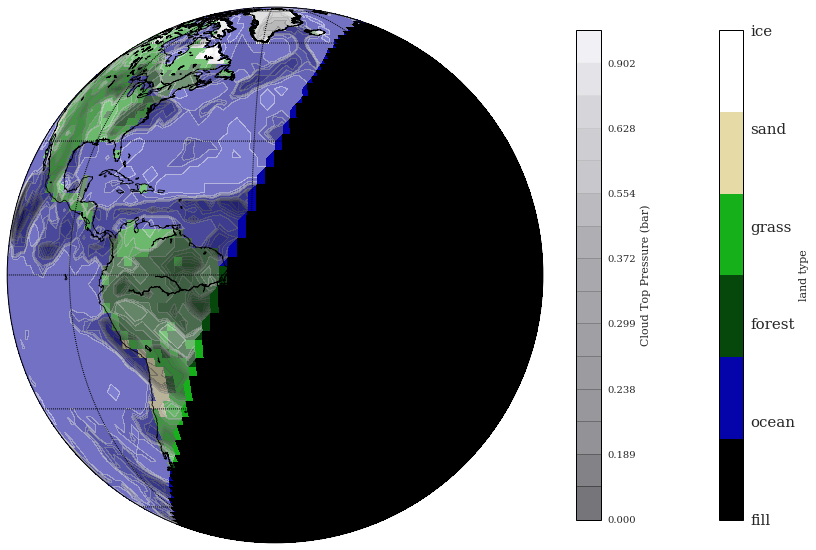

In [20]:

'''
THESE ARE THE GOOD PLOTS READY FOR PUBLICATION
'''

fig = plt.figure(figsize=(15,15))
    
plt.rc('font', family='serif', weight = 545, size = 15)

m = Basemap(projection='ortho', resolution='l', lat_0=0, lon_0 = -39.8333)
#   ^ to plot on a globe 

m.drawcoastlines(linewidth=0.8)
m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 45.), labels=[0, 0, 0, 1])

lat = np.arange(-90,89,2)
lon = np.arange(-180,180,2)

x, y = m(*np.meshgrid(lon, lat))

ax1 = m.pcolor(x, y, land[::-1], cmap=plt.cm.get_cmap(my_cmap,6))

plt.clim(0,5)

cbar = plt.colorbar(ax1, label='land type', orientation='vertical', ticks=range(6), shrink = 0.6)
cbar.outline.set_edgecolor('xkcd:black')
cbar.outline.set_linewidth(1)
cbar.ax.set_yticklabels(['fill', 'ocean', 'forest', 'grass', 'sand', 'ice'], {'fontsize':15})
cbar.outline.set_label({'fontsize':15})

ax2 = m.contourf(x, y, ctp[::-1], levels = ctp_bins, alpha = 0.5, cmap='Greys_r')

contour_bar = plt.colorbar(ax2, label = 'Cloud Top Pressure (bar)', orientation='vertical', shrink = 0.6)
contour_bar.outline.set_edgecolor('xkcd:black')
contour_bar.outline.set_linewidth(1)
#cax = contour_bar.ax
#contour_bar.ax.set_yticklabels(ctpbins, {'fontsize':15})

'''
cb_ax = contour_bar.ax
ax.text(1.3,0.5,r'$\tau$',rotation=90)
'''
#plt.title('2x2 Degree Land Cover of Earth as Seen from the Moon w/ Cloud Top Pressure - 5/18/13 21:20 UTC', {'fontsize':15})

#plt.savefig('landcover_ctp.pdf')
plt.show()

7-30-18

I'm going to try to use gridspec to create more professional plots, using Devin's github
notebooks as reference

In [91]:
from matplotlib import gridspec as gridspec
import cartopy
import cartopy.crs as ccrs

                Geostationary, Orthographic or Azimuthal equidistant basemap
                

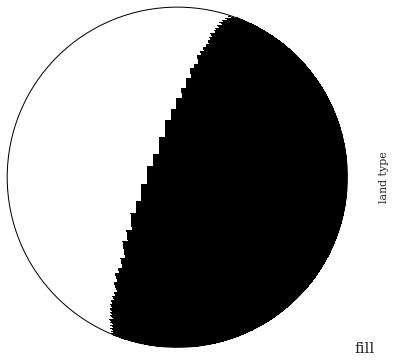

In [26]:
#plt.close(1)
fig = plt.figure(figsize=(7.6,8))

m = Basemap(projection='ortho', resolution='l', lat_0=0, lon_0 = -39.8333)
#   ^ to plot on a globe 

m.drawcoastlines()
m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 45.), labels=[0, 0, 0, 1])

lat = np.arange(-90,89,2)
lon = np.arange(-180,180,2)

x, y = m(*np.meshgrid(lon, lat))


gs = gridspec.GridSpec(1,3, height_ratios=[1], width_ratios=[0.05,1,0.05])

#----SUBPLOT 1----#


ax2 = plt.subplot(gs[0,1])


plt1 = m.pcolor(x, y, land[::-1], ax = ax2, cmap=plt.cm.get_cmap(my_cmap,6), clim = (0,5))


#plt2 = m.contourf(x, y, ctp[::-1], levels = ctp_bins, alpha = 0.2, cmap='Greys_r')

#----SUBPLOT 2-----#

#cbax = plt.subplot(gs[0,2]) # Place it where it should be.
cbar = plt.colorbar(mappable = plt1, cax = ax2, label = 'land type', orientation='vertical', ticks=range(6))
cbar.outline.set_edgecolor('xkcd:black')
cbar.outline.set_linewidth(1)
cbar.ax.set_yticklabels(['fill', 'ocean', 'forest', 'grass', 'sand', 'ice'], {'fontsize':15})
cbar.outline.set_label({'fontsize':20})

#ax2 = plt.subplot(gs[0,0])

#----SUBPLOT 3----#
#cbax = plt.subplot(gs[0,0])

# Left
'''
cbax = plt.subplot(gs[0,0]) # Place it where it should be.
cb = plt.colorbar(cax = cbax, mappable = plt2, orientation = 'vertical', ticklocation = 'left')
cb.set_label(r'Colorbar !', labelpad=10)
'''
plt.show()

In [98]:
fig = plt.figure(figsize=(15,15))
    
plt.rc('font', family='serif', weight = 545, size = 15)


m = Basemap(projection='ortho', resolution='l', lat_0=0, lon_0 = -39.8333)
#   ^ to plot on a globe 

m.drawcoastlines(linewidth=0.8)
m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 45.), labels=[0, 0, 0, 1])

lat = np.arange(-90,89,2)
lon = np.arange(-180,180,2)

x, y = m(*np.meshgrid(lon, lat))

ax1 = m.pcolor(x, y, land[::-1], cmap=plt.cm.get_cmap(my_cmap,6))
plt.clim(0,5)

cbar = plt.colorbar(ax1, label = 'land type', orientation='vertical', ticks=range(6), shrink = 0.64)
cbar.outline.set_edgecolor('xkcd:black')
cbar.outline.set_linewidth(1)
cbar.ax.set_yticklabels(['fill', 'ocean', 'forest', 'grass', 'sand', 'ice'], {'fontsize':15})
cbar.outline.set_label({'fontsize':20})

ax2 = m.contourf(x, y, ctp[::-1], levels = ctp_bins, alpha = 0.5, cmap='Greys_r')

contour_bar = plt.colorbar(ax2, label = 'Cloud Top Pressure (bar)', orientation='vertical', shrink = 0.64)
contour_bar.outline.set_edgecolor('xkcd:black')
contour_bar.outline.set_linewidth(1)
cax = contour_bar.ax
#contour_bar.ax.set_yticklabels(ctpbins, {'fontsize':15})

#pos2 = [pos1.x0 + 0.3, pos1.y0 + 0.3,  pos1.width / 2.0, pos1.height / 2.0] 


plt.title('2x2 Degree Land Cover of Earth as Seen from the Moon w/ Cloud Top Pressure - 5/18/13 21:20 UTC',
          {'fontsize':15},
          loc = 'left')

#plt.savefig('landcover_ctp.pdf')

#plt.tight_layout()
plt.show()

                Geostationary, Orthographic or Azimuthal equidistant basemap
                

RuntimeError: LaTeX was not able to process the following string:
'lp'
Here is the full report generated by LaTeX: 



In [ ]:
### from Devin's code

def set_gridspec(widths=[12], heights=[12], wspace=0, hspace=0):
    fig = plt.figure(figsize=(sum(widths) + wspace * (len(widths) - 1),
                              sum(heights) + hspace * (len(heights) - 1)))
    gs = gridspec.GridSpec(len(heights), len(widths),
                           height_ratios=heights, width_ratios=widths)
    return fig, gs

In [ ]:
fig, gs = set_gridspec(widths=[75], heights=[10, 10])

ax = fig.add_subplot(gs[0])

## 1.6 Micron Data

Now I make the same plots of land cover/ cloud props, but with 1.6 $\mu$m data from MODIS. I choose to use the liquid cloud cloud optical thickness and cloud top pressure instead of ice cot/ctp.

In [8]:
sdslist_16 = ['Cloud_Optical_Thickness_16_Liquid_Mean', 'Cloud_Optical_Thickness_16_Ice_Mean']

liq_16, ice_16 = cloudtypes(cloudfile, sdslist_16, cot_bins, cot_bins, daynight, is_ctp = False)
liq_16_crude, ice_16_crude = cloudtypes(cloudfile, sdslist_16,
                                        cot_bins_crude, cot_bins_crude, daynight, is_ctp = False)

In [25]:
###--------UNIQUE COMBO PLOT--------###

fig = plt.figure(figsize=(15,15))
    
plt.rc('font', family='serif', weight = 545, size = 15)

m = Basemap(projection='ortho', resolution='l', lat_0=0, lon_0 = -39.8333)
#   ^ to plot on a globe 
    
m.drawcoastlines(linewidth=0.8)
m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 45.), labels=[0, 0, 0, 1])

lat = np.arange(-90,89,2)
lon = np.arange(-180,180,2)

x, y = m(*np.meshgrid(lon, lat))

ax1 = m.pcolor(x, y, land[::-1], cmap=plt.cm.get_cmap(my_cmap,6))

plt.clim(0,5)

cbar = plt.colorbar(ax1, label = 'land type', orientation='vertical', ticks=range(6), shrink = 0.6)
cbar.outline.set_edgecolor('xkcd:black')
cbar.outline.set_linewidth(1)
cbar.ax.set_yticklabels(['fill', 'ocean', 'forest', 'grass', 'sand', 'ice'], {'fontsize':15})
cbar.outline.set_label({'fontsize':20})

ax2 = m.contourf(x, y, ctp[::-1], levels = ctp_bins, alpha = 0.5, cmap='Greys_r')

contour_bar = plt.colorbar(ax2, label = 'Cloud Top Pressure (bar)', orientation='vertical', shrink = 0.6)
contour_bar.outline.set_edgecolor('xkcd:black')
contour_bar.outline.set_linewidth(1)
cax = contour_bar.ax
#contour_bar.ax.set_yticklabels(ctpbins, {'fontsize':15})


plt.title('2x2 Degree Land Cover of Earth as Seen from the Moon w/ Cloud Top Pressure - 5/18/13 21:20 UTC', {'fontsize':15})

plt.savefig('landcover_ctp.pdf')
#plt.show()

                Geostationary, Orthographic or Azimuthal equidistant basemap
                

In [ ]:
###--------SINGLE PARAMETER PLOT--------###

fig = plt.figure(figsize=(15,15))
    
plt.rc('font', family='serif', weight = 545, size = 15)

m = Basemap(projection='ortho', resolution='l', lat_0=0, lon_0 = -39.8333)
#   ^ to plot on a globe 

m.drawcoastlines(linewidth=0.8)
m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 45.), labels=[0, 0, 0, 1])

lat = np.arange(-90,89,2)
lon = np.arange(-180,180,2)

x, y = m(*np.meshgrid(lon, lat))

ax1 = m.pcolor(x, y, ice_16[::-1], 
               cmap=plt.cm.get_cmap('viridis',len(cot_bins)))

plt.clim(0, len(cot_bins) - 1)

cbar = plt.colorbar(ax1,
                    label = r'Cloud Optical Thickness 1.6 $\mu$m (bar)',
                    orientation = 'vertical',
                    ticks=range(len(cot_bins)),
                    shrink = 0.6)

cbar.outline.set_edgecolor('xkcd:black')
cbar.outline.set_linewidth(1)
cbar.ax.set_yticklabels(cot_bins, {'fontsize':15})
cbar.outline.set_label({'fontsize':20})
plt.legend()


plt.title('2x2 Degree Land Cover of Earth as Seen from the Moon w/ Cloud Optical Thickness - 5/18/13 21:20 UTC', {'fontsize':15})

#plt.savefig('landcover_ctp.pdf')
plt.show()

In [ ]:
def simplehist(dat, bins, xlabel, title): 
    
    sns.set()

    fig = plt.figure( figsize = (25,15) )

    plt.hist(dat, bins = bins, range = (min(bins), max(bins)))  # add additional value because last bin is inclusive

    plt.xlabel('Cloud Top Pressure (bar)')
    plt.xticks(bins)
    plt.ylabel('Counts')
    plt.title(title)

    plt.show()
    #plt.savefig('histogram_ctp_reduced.png')
    
simplehist(liq_16.flatten(), cot_bins, 
           'COT Liquid', 
           'Histogram Liquid COT for 2x2 Degree Lit Earth as Seen Moon')

## Now, a function for finding unique combinations

In [10]:
def unique_combos(arr1, arr2, arr3):
    
    '''
    Takes 3 arrays of the same shape, returns an array containing lists of each unique 
    combination of the three arrays at each place in the arrays.
    
    INPUTS: arr1, arr2, arr3 - 2D numpy arrays 
    
    OUTPUTS: combos - list containing lists (each of length 3) of each unique combination
    '''
    
    itdat = range(len(arr1))
    itdat2 = range(len(arr1[0]))
    
    arr1_new = copy.deepcopy(arr1)
    arr2_new = copy.deepcopy(arr2)
    arr3_new = copy.deepcopy(arr3)
    
    for i in itdat:
        for j in itdat2:
            if np.isnan(arr1_new[i][j]) == True:
                arr1_new[i][j] = -9999.0
            if np.isnan(arr2_new[i][j]) == True:
                arr2_new[i][j] = -9999.0
            if np.isnan(arr3_new[i][j]) == True:
                arr3_new[i][j] = -9999.0
    
    #print arr1_new[np.isnan(arr1_new) == True]
    
    combo_list = [[arr1_new[i][j], arr2_new[i][j], arr3_new[i][j]]
                                for i in itdat
                                for j in itdat2]
    
    combos = []
    
    for i in combo_list:
        if i not in combos:
            combos.append(i)

    return combos

In [11]:
combos_liq = unique_combos(land, liq_16, ctp)
combos_ice = unique_combos(land, ice_16, ctp)

combos_liq_crude = unique_combos(land, liq_16_crude, ctp)
combos_ice_crude = unique_combos(land, ice_16_crude, ctp)

print len(combos_liq)
print len(combos_ice)

print len(combos_liq_crude)
print len(combos_ice_crude)

520
567
385
432


In [12]:
#crude_cot = rebindat(cot, cot_bins_crude)

combos_orig = unique_combos(land, cot, ctp)
combos_crude = unique_combos(land, cot_crude, ctp)

combos_orig_redo = unique_combos(cot, ctp, land)

print len(combos_orig)
print len(combos_crude)
print len(combos_orig_redo)

540
390
540


In [36]:
print combos_orig

[[-9999.0, -9999.0, -9999.0], [1, 25.0, 0.90200000000000002], [1, 20.0, 0.90200000000000002], [1, 16.0, 0.90200000000000002], [1, 30.0, 0.90200000000000002], [1, 18.0, 0.90200000000000002], [1, 35.0, 0.90200000000000002], [1, 12.0, 0.90200000000000002], [1, 14.0, 0.90200000000000002], [1, 40.0, 0.90200000000000002], [1, 52.0, 0.90200000000000002], [1, 6.0, 1.03], [1, 8.0, 1.03], [1, 8.0, 0.90200000000000002], [1, 10.0, 0.90200000000000002], [1, 12.0, 1.03], [1, 30.0, 1.03], [1, 35.0, 1.03], [1, 40.0, 1.03], [1, 35.0, 0.70999999999999996], [1, 25.0, 0.70999999999999996], [1, 30.0, 0.70999999999999996], [1, 40.0, 0.70999999999999996], [1, 52.0, 0.70999999999999996], [1, 100.0, 1.03], [1, -9999.0, -9999.0], [1, 10.0, 1.03], [1, 4.0, 1.03], [1, 20.0, 0.70999999999999996], [1, 12.0, 0.70999999999999996], [1, 6.0, 0.90200000000000002], [5, 6.0, 0.90200000000000002], [5, 8.0, 0.90200000000000002], [4, 8.0, 0.90200000000000002], [1, 14.0, 1.03], [1, 20.0, 1.03], [1, 25.0, 1.03], [1, 30.0, 0.62

In [13]:
print ice_16[np.isnan(ice_16) != True]

[ 30.  25.  25. ...,  35.  10.  40.]


Here, I test the unique_combos function with various test arrays

In [ ]:
# TEST LISTS
[1., 1., 1.]
[3., 2., 1.]
[2., 2., 2.]
[1., 2., 3.]

In [26]:
test1 = np.array([[1., 1., 1., 1., 1., 1., 2.], [2., 3., 2., 1., 3., 2., 1.]])

test2 = np.array([[1., 2., 3., 3., 2., 1., 1.], [1., 1., 2., 3., 1., 2., 3.]])

test3 = np.array([[1., 1., 1., 3., 2., 1., 2.], [2., 1., 1., 1., 1., 1., 1.]])

# there are 4 unique combos

print len(unique_combos(test1, test2, test3))

8


In [24]:
print test1[0][0]

1.0


In [58]:
ctp_copy = copy.deepcopy(ctp)
land_copy = copy.deepcopy(land)
cot_copy = copy.deepcopy(cot)

print ctp_copy[np.isnan(ctp_copy) != True]

for i in range(len(ctp_copy)):
        for j in range(len(ctp_copy[i])):
            if np.isnan(land_copy[i][j]) == True:
                land_copy[i][j] = -9999.0
            if np.isnan(cot_copy[i][j]) == True:
                cot_copy[i][j] = -9999.0
            if np.isnan(ctp_copy[i][j]) == True:
                ctp_copy[i][j] = -9999.0
            
print ctp_copy[ctp_copy != -9999.]


'''
combo_list = [[land_copy[i][j], cot_copy[i][j], ctp_copy[i][j]]
                                for i in range(len(ctp_copy))
                                for j in range(len(ctp_copy[i]))]
'''
combo_list = []
for i in range(len(ctp_copy)):
    for j in range(len(ctp_copy[i])):
        sample = []
        #combo_list.append([land_copy[i][j], cot_copy[i][j], ctp_copy[i][j]])
        #print ctp_copy[i][j]
        a = land_copy[i][j]
        b = cot_copy[i][j]
        c = ctp_copy[i][j]
        
        sample.append(a)
        sample.append(b)
        sample.append(c)
        
        combo_list.append(sample)
        
#print combo_list

boom = []

for i in combo_list:
    if i not in boom:
        boom.append(i)
        
print len(boom)

[ 0.902  0.902  0.902 ...,  0.554  0.411  0.411]
[ 0.902  0.902  0.902 ...,  0.554  0.411  0.411]
501


In [31]:
ascii.write(ctp.T, 'ctp_moonview.txt')